# Differential Test of CLgen kernels

Run CLgen kernels on two different devices using the same inputs.

Record any outputs which differ.

In [1]:
import clgen
clgen.platform_info()

CLgen:      0.2.9 (with CUDA)
Platform:   Linux
Memory:     32057 MB

Device:     GPU GeForce GTX 1080
Compute #.: 20
Frequency:  1733 HZ
Memory:     8114 MB
Driver:     375.39

Device:     GPU GeForce GTX 1080
Compute #.: 20
Frequency:  1733 HZ
Memory:     8114 MB
Driver:     375.39

Device:     CPU Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz
Compute #.: 16
Frequency:  2100 HZ
Memory:     32057 MB
Driver:     1.2.0.25


## 1. Experimental Results

Datasets:

In [2]:
!ls -lh data/difftest/

total 107M
-rw-r--r-- 1 cec cec  58M Mar 21 17:30 cpu.db
-rw-rw-r-- 1 cec cec 1.8M Mar 21 17:30 cpu.log
-rw-r--r-- 1 cec cec  46M Mar 21 17:30 gpu.db
-rw-rw-r-- 1 cec cec 2.1M Mar 21 17:30 gpu.log
drwxrwxr-x 2 cec cec 4.0K Mar 26 09:29 reports
drwxrwxr-x 2 cec cec 4.0K Mar 26 09:28 verified


Load datasets. Set `in1` and `in2` appropriately:

In [3]:
from clgen import dbutil
from labm8 import fs

in1 = fs.path("data/difftest/cpu.db")
in2 = fs.path("data/difftest/gpu.db")

in1base = fs.basename(in1)
in2base = fs.basename(in2)

db1 = dbutil.connect(in1)
db2 = dbutil.connect(in2)

c1 = db1.cursor()
c2 = db2.cursor()

c1.execute("ATTACH DATABASE '{in2}' AS rhs".format(**vars()))
c2.execute("ATTACH DATABASE '{in1}' AS rhs".format(**vars()))

# num results
n1 = dbutil.num_rows_in(in1, "Data")
n2 = dbutil.num_rows_in(in2, "Data")

# metadata
device1 = dbutil.get_meta(in1, "device")
device2 = dbutil.get_meta(in2, "device")

host1 = dbutil.get_meta(in1, "host")
host2 = dbutil.get_meta(in2, "host")

c1.execute("""
SELECT COUNT(*)
FROM Data AS lData INNER JOIN rhs.Data AS rData ON lData.id=rData.id
""")
n3 = c1.fetchone()[0]

c1.execute("""
SELECT
    lData.id AS id,
    lData.status AS lstatus, rData.status AS rstatus,
    lData.result AS ldata, rData.result AS rdata
FROM Data AS lData INNER JOIN rhs.Data AS rData ON lData.id=rData.id
WHERE lData.result != "" AND rData.result != ""
""")
cdata = c1.fetchall()
ncdata = len(cdata)

print("""\
Number of results for {device1} on {host1}: {n1}.
Number of results for {device2} on {host2}: {n2}.
Number of common results: {n3}.
Number of common good results: {ncdata}.\
""".format(**vars()))

Number of results for Intel(R) Xeon(R) CPU E5-2620 v4 @ 2.10GHz on cc1: 13489.
Number of results for GeForce GTX 1080 on cc1: 18070.
Number of common results: 5129.
Number of common good results: 940.


## 2. Evaluation

### Per-device results

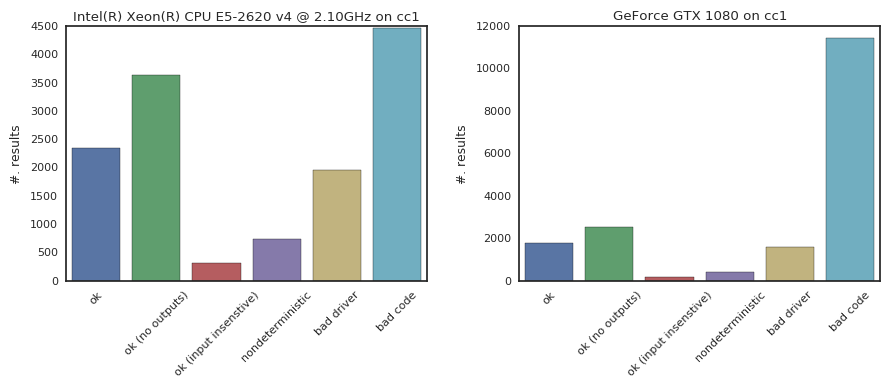

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from labm8 import viz

plt.style.use(["seaborn-white", "seaborn-paper"])
%matplotlib inline

STATUS = ["ok", "ok (no outputs)", "ok (input insenstive)", "nondeterministic", "bad driver", "bad code"]

def plot_dist(path):
    basename = fs.basename(path)
    c = dbutil.connect(path).cursor()
    c.execute("SELECT status, COUNT(status) FROM Data GROUP BY status ORDER BY status")
    d = [{"status": STATUS[i], "n": x} for i, x in c.fetchall()]
    ax = sns.barplot(x="status", y="n", data=pd.DataFrame(d))
    device = dbutil.get_meta(path, "device")
    host = dbutil.get_meta(path, "host")
    plt.title("{device} on {host}".format(**vars()))
    plt.setp(ax.get_xticklabels(), rotation=45)  # rotate x ticks
    plt.xlabel("")
    plt.ylabel("#. results")

ax = plt.subplot(1, 2, 1)
plot_dist(in1)
ax = plt.subplot(1, 2, 2)
plot_dist(in2)

viz.finalise(figsize=(9, 4))

### Generate reports

In [5]:
# write report files to:
reportdir = "data/difftest/reports"
fs.mkdir(reportdir)

!rm -rf data/difftest/reports/*.txt

In [6]:
import json
import sys

from difflib import unified_diff
from clgen.clutil import KernelPrototype

numstatusdiff = 0
numdatadiff = 0

def get_src(c, id):
    c.execute("SELECT Source FROM Source WHERE id=?", (id,))
    r = c.fetchone()
    assert(len(r) == 1)
    return r[0]

for row in cdata:
    id, lstatus, rstatus, ldata, rdata = row

    if ldata != rdata:
        reportpath = fs.path(reportdir, "{id}-data.txt".format(**vars()))
        print("Data diff:", fs.basename(reportpath))        

        src1 = get_src(c1, id)
        src2 = get_src(c2, id)
        assert(src1 == src2)  # sanity check for hash collisions

        src_size = len(src1.split('\n'))
        prototype = KernelPrototype.from_source(src1)
        
        report = """\
===================================================
Kernel {id} ({src_size} lines):
===================================================

{src1}
""".format(**vars())
        
        srcpath = fs.path(reportdir, "{id}".format(**vars()))
        with open(srcpath, "w") as outfile:
            print(src1, file=outfile)
            
        ld = json.loads(ldata)
        rd = json.loads(rdata)
        assert(len(ld) == len(rd))  # payloads should have same length
        for i, r in enumerate(zip(ld, rd)):
            a1, a2 = r
            if a1 != a2:
                assert(len(a1) == len(a2))
   
                argtype = prototype.args[i]
                t1 = ["{}\n".format(x) for x in a1]
                t2 = ["{}\n".format(x) for x in a2]

                diff = list(unified_diff(t1, t2, fromfile=device1, tofile=device2))
                diff_size = len(diff)
                diff = ''.join(diff)

                report += """\

===================================================
Output diff ({diff_size} lines) for arg {i}: {argtype}
===================================================

{diff}
""".format(**vars())
        
        with open(reportpath, "w") as reportfile:
            print(report, file=reportfile)
        numdatadiff += 1
    elif lstatus != rstatus:
        reportpath = fs.path(reportdir, "{id}-status.txt".format(**vars()))
        print("Status mismatch:", fs.basename(reportpath))
        
        STATUS = ["ok", "ok (no outputs)", "ok (input insenstive)", "nondeterministic", "bad driver", "bad code"]
        lstatus_txt = STATUS[lstatus]
        rstatus_txt = STATUS[rstatus]
        
        src1 = get_src(c1, id)
        src2 = get_src(c2, id)
        assert(src1 == src2)  # sanity check for hash collisions

        src_size = len(src1.split('\n'))

        report = """\
===================================================
Kernel {id} ({src_size} lines):
===================================================

{src1}

===================================================
Status mismatch:
===================================================

On {device1}: {lstatus_txt}
On {device2}: {rstatus_txt}
""".format(**vars())
        
        with open(reportpath, "w") as reportfile:
            print(report, file=reportfile)
        numstatusdiff += 1

n = len(cdata)
ratiostatusdiff = numstatusdiff / n
ratiodatadiff = numdatadiff / n

Data diff: 2706a7641f6178a675e80452fbfeca7ff3102b61.cl-data.txt
Status mismatch: dcae239e1575c36df29326d586a6f9d70e57fb43.cl-status.txt
Status mismatch: 9a16d4ce0fc164cb819a2a7c1508db9bd46629b5.cl-status.txt
Data diff: e6b800e780afb35834c7d3ae96bbe57614e672fd.cl-data.txt
Data diff: 8438b222e9a30fee8e0ba7910f1cd16d0c6ff9e8.cl-data.txt
Data diff: 1ba6c22be25beda62bbef93cffec60c7c0970aae.cl-data.txt
Data diff: 2a7583ba751fcc43999838e557f4257c58ce485e.cl-data.txt
Data diff: 3de6c77341cfe05fe061ccbded043992094a170e.cl-data.txt
Data diff: d745ff1ac43d192305833d0eee51df7cb8471603.cl-data.txt
Data diff: cc4bd1b35e3f5181dc8bb084588ab48b24f349a4.cl-data.txt
Data diff: cb21ab8e7056fa503d2d6100229cdae10aa26551.cl-data.txt
Data diff: 2e202fb8472dd387791f1135f7e66e14e0c530cf.cl-data.txt
Data diff: 19f51ce8f48716a0aea3083ceb1cf3453dacbec5.cl-data.txt
Data diff: c3931a439a77f4130dcdd8874840b9b126348a42.cl-data.txt
Data diff: 78434994bda77b8c9fb6b50d68be4e73b98b8151.cl-data.txt
Data diff: 1df64378ef0bf

In [7]:
print("Of {n} results, {numstatusdiff} ({ratiostatusdiff:.2%}) resuulted in different statuses".format(**vars()))
print("Of {n} results, {numdatadiff} ({ratiodatadiff:.2%}) resulted in different data".format(**vars()))

Of 940 results, 4 (0.43%) resuulted in different statuses
Of 940 results, 64 (6.81%) resulted in different data


## Run GPUVerify on diff kernels

"diff" kernels are those which have a difference in the computed data or runtime status when ran on different hardware.

In [10]:
from clgen import preprocess

src = """\
__kernel void A(__global int* a) {
  a[get_global_id(0)] *= 2.0f;
}
"""

print(preprocess.gpuverify(src, ["--local_size=64", "--num_groups=128"]))

__kernel void A(__global int* a) {
  a[get_global_id(0)] *= 2.0f;
}



In [11]:
!rm -rf data/difftest/verified

import sys
kernels = [x for x in fs.ls(fs.path("data/difftest/reports"), abspaths=True) if x.endswith(".cl")]

fs.mkdir("data/difftest/verified")

err_count = 0
for path in kernels:
    with open(path) as infile:
        print(path)
        src = infile.read()
        try:
            preprocess.gpuverify(src, ["--local_size=64", "--num_groups=128"])
            
            outpath = fs.path("data/difftest/verified", fs.basename(path))
            with open(outpath, "w") as outfile:
                print(src, file=outfile)
        except preprocess.GPUVerifyException as e:
            outpath = fs.path("data/difftest/verified", fs.basename(path) + ".report")
            with open(outpath, "w") as outfile:
                print(e, file=outfile)
            err_count += 1

/home/cec/src/project_b/data/difftest/reports/04a16f578844d69c2a807dd494d7017af29d245a.cl
/home/cec/src/project_b/data/difftest/reports/0ed6e85e4289df27e83830231e3abf60742d6695.cl
/home/cec/src/project_b/data/difftest/reports/17e6c8bcee409d5db27fbbc60f22e58e50aed6d6.cl
/home/cec/src/project_b/data/difftest/reports/19f51ce8f48716a0aea3083ceb1cf3453dacbec5.cl
/home/cec/src/project_b/data/difftest/reports/1ba6c22be25beda62bbef93cffec60c7c0970aae.cl
/home/cec/src/project_b/data/difftest/reports/1df64378ef0bf6c406b2cb0ccc1012ddd6f65c60.cl
/home/cec/src/project_b/data/difftest/reports/1e7ec8f208eaf040e25f9bae47232c17d9b5892d.cl
/home/cec/src/project_b/data/difftest/reports/20e78fde43680b5832a80409fa64ae99dec36fd7.cl
/home/cec/src/project_b/data/difftest/reports/255409f28fe8056cf6072e6de09a7d1b86f4a23e.cl
/home/cec/src/project_b/data/difftest/reports/26496231dee4b4696b399b9caab80e57e37047a7.cl
/home/cec/src/project_b/data/difftest/reports/2706a7641f6178a675e80452fbfeca7ff3102b61.cl
/home/cec/

In [12]:
n = len(kernels)
err_ratio = err_count / n

print("Of {n} kernels, {err_count} ({err_ratio:.2%}) were found by GPUVerify to contain errors.".format(**vars()))

Of 64 kernels, 34 (53.12%) were found by GPUVerify to contain errors.


## Run Oclgrind on verified kernels

In [24]:
import subprocess
from clgen import native

def oclgrind(path):
    _oclgrind = native.OCLGRIND
    print(path)
    out = subprocess.check_output([_oclgrind, "cldrive", path])
    print(out.decode('utf-8'))

kernels = [x for x in fs.ls(fs.path("data/difftest/verified"), abspaths=True) if x.endswith(".cl")]

# err_count = 0
for path in kernels:
    with open(path) as infile:
        oclgrind(path)

/home/cec/src/project_b/data/difftest/reports/04a16f578844d69c2a807dd494d7017af29d245a.cl
04a16f578844d69c2a807dd494d7017af29d245a.cl,256,A,Oclgrind,Oclgrind Simulator,256,4096,42.783744
04a16f578844d69c2a807dd494d7017af29d245a.cl,256,A,Oclgrind,Oclgrind Simulator,256,4096,26.533888
04a16f578844d69c2a807dd494d7017af29d245a.cl,256,A,Oclgrind,Oclgrind Simulator,256,4096,6.961152
04a16f578844d69c2a807dd494d7017af29d245a.cl,256,A,Oclgrind,Oclgrind Simulator,256,4096,6.571008
04a16f578844d69c2a807dd494d7017af29d245a.cl,256,A,Oclgrind,Oclgrind Simulator,256,4096,6.774016
04a16f578844d69c2a807dd494d7017af29d245a.cl,256,A,Oclgrind,Oclgrind Simulator,256,4096,6.624256
04a16f578844d69c2a807dd494d7017af29d245a.cl,256,A,Oclgrind,Oclgrind Simulator,256,4096,6.816000
04a16f578844d69c2a807dd494d7017af29d245a.cl,256,A,Oclgrind,Oclgrind Simulator,256,4096,7.403008
04a16f578844d69c2a807dd494d7017af29d245a.cl,256,A,Oclgrind,Oclgrind Simulator,256,4096,6.767872
04a16f578844d69c2a807dd494d7017af29d245a.cl,